The goal of this project is to use unsupervised learning techniques to identify wine categories. Our dataset is composed of 11 numerical physical-chemical measurements which will be used by a gaussian mixture model to identify these distinct categories. We will not assume any particular number of clusters beforehand but will rather use the silhouette score as an indicator of the best number of clusters to segment our data by. Our dataset is a combination of a red wine dataset and a white wine dataset but we will not use the color by our clustering algorithm. Instead, we are interested in whether our algorithm will naturally segment wine into white and red categories. 

The dataset can be found here:
http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/

In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
import random
from IPython.display import display #for displaying dataframes nicely
import matplotlib.pyplot as plt


random.seed(137)

In [2]:
#combine red and white datasets
reds= pd.read_csv('winequality-red.csv')
reds['type']= 'red'
whites= pd.read_csv('winequality-white.csv')
whites['type']='white'

#drop the "quality" column as it is not a physical property that we are interested in
wines= pd.concat([reds, whites])
wines.drop(columns=['quality'], inplace=True)

In [3]:
print('rows, columns: {}'.format(wines.shape))
display(wines.head())

rows, columns: (6497, 12)


fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol type  
0      9.4  red  
1      9.8  red  
2      9.8  red  
3      9.8  red  
4      9.4  red

In [4]:
wines.describe()

fixed acidity  volatile acidity  citric acid  residual sugar  \
count    6497.000000       6497.000000  6497.000000     6497.000000   
mean        7.215307          0.339666     0.318633        5.443235   
std         1.296434          0.164636     0.145318        4.757804   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.400000          0.230000     0.250000        1.800000   
50%         7.000000          0.290000     0.310000        3.000000   
75%         7.700000          0.400000     0.390000        8.100000   
max        15.900000          1.580000     1.660000       65.800000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  6497.000000          6497.000000           6497.000000  6497.000000   
mean      0.056034            30.525319            115.744574     0.994697   
std       0.035034            17.749400             56.521855     0.002999   
min       0.009000             1.000000              6.000000     0.987110   
25%       0.038000            17.000000             77.000000     0.992340   
50%       0.047000            29.000000            118.000000     0.994890   
75%       0.065000            41.000000            156.000000     0.996990   
max       0.611000           289.000000            440.000000     1.038980   

                pH    sulphates      alcohol  
count  6497.000000  6497.000000  6497.000000  
mean      3.218501     0.531268    10.491801  
std       0.160787     0.148806     1.192712  
min       2.720000     0.220000     8.000000  
25%       3.110000     0.430000     9.500000  
50%       3.210000     0.510000    10.300000  
75%       3.320000     0.600000    11.300000  
max       4.010000     2.000000    14.900000

As seen above, our values have very different ranges. We will need to rescale our data for optimal performance with typical machine learning algorithms. Before doing so, let's check for highly correlated features. If some features are found to be highly correlated, they will likely be redundant in the learning process and we can drop all but one of each group of highly correlated features. 

<IPython.core.display.Javascript object>


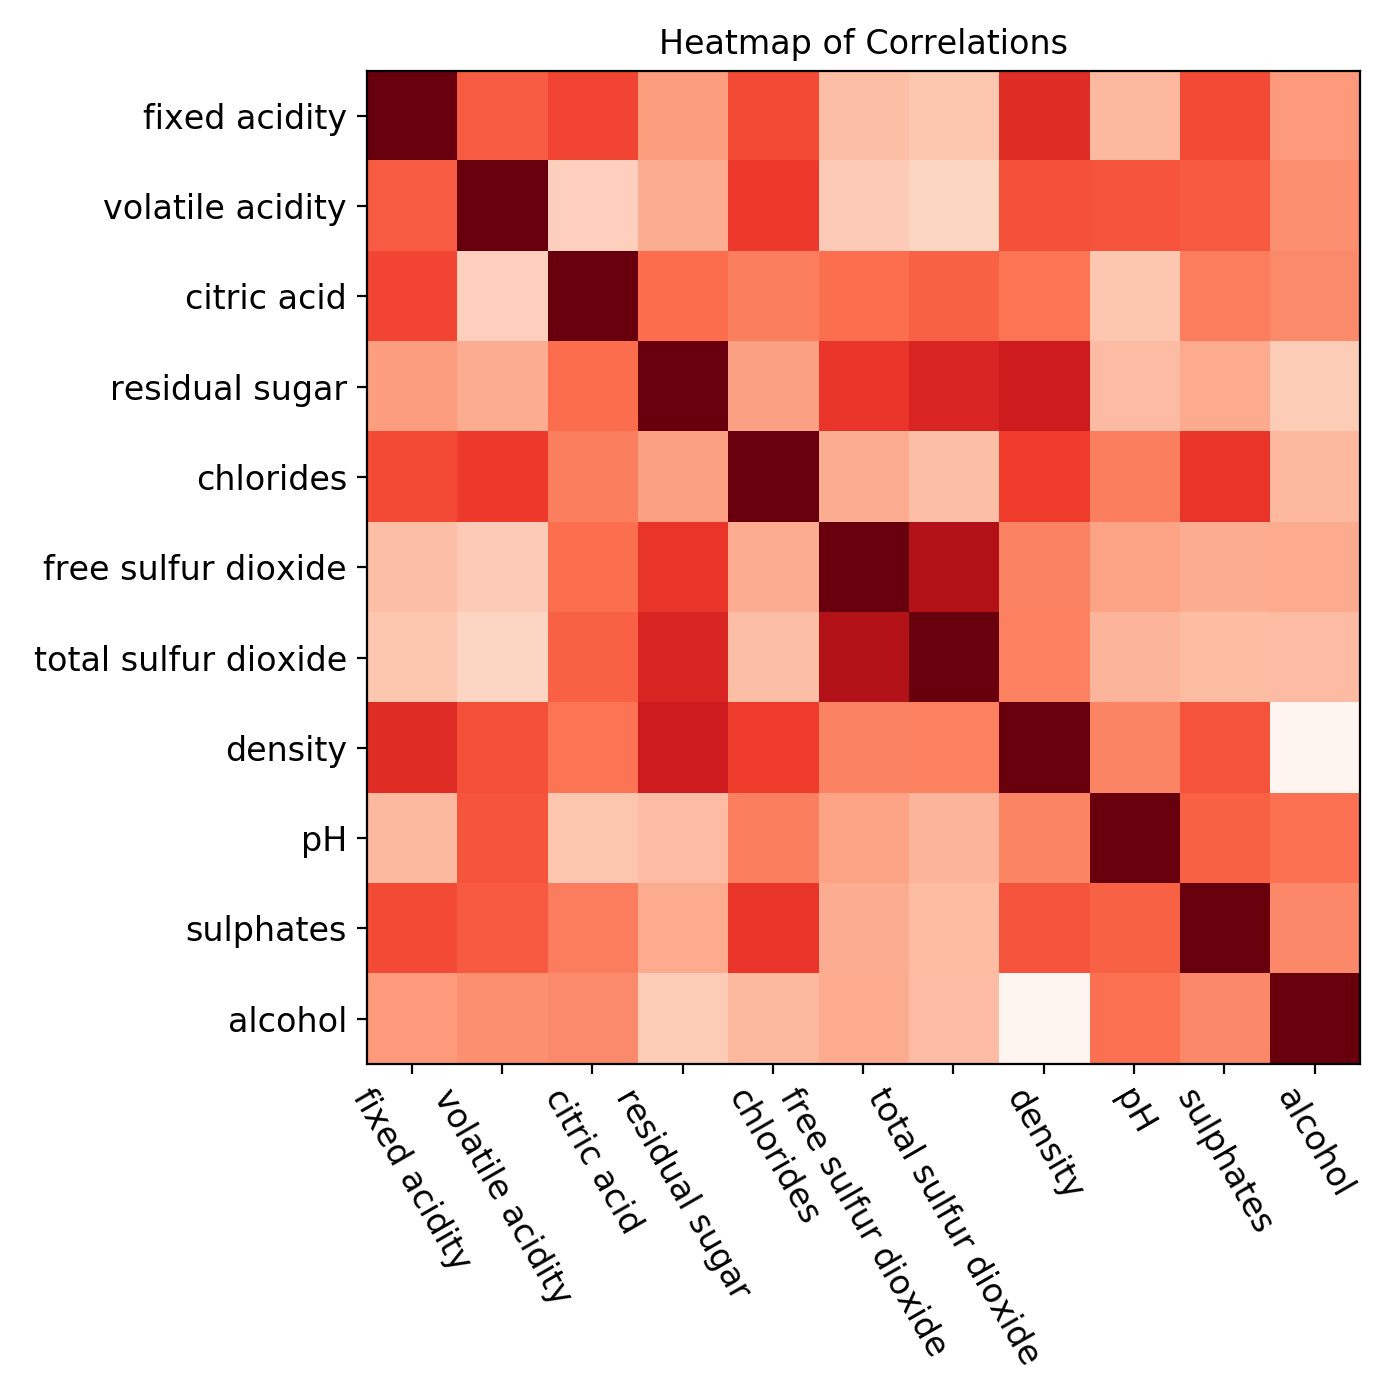

In [5]:
#Use a heatmap to visualize the greatest correlations
plt.style.use('default')
plt.figure(figsize=(7, 7))
plt.imshow(wines.corr(), cmap='Reds', interpolation= 'nearest')
plt.xticks(np.arange(len(wines.corr().index.values)), wines.corr().index.values, fontsize=12, rotation=-60)
plt.yticks(np.arange(len(wines.corr().index.values)), wines.corr().index.values, fontsize=12)
plt.title('Heatmap of Correlations')
plt.tight_layout()
plt.show()

In [6]:
#View the numeric data corresponding to the above
wines.corr()

fixed acidity  volatile acidity  citric acid  \
fixed acidity              1.000000          0.219008     0.324436   
volatile acidity           0.219008          1.000000    -0.377981   
citric acid                0.324436         -0.377981     1.000000   
residual sugar            -0.111981         -0.196011     0.142451   
chlorides                  0.298195          0.377124     0.038998   
free sulfur dioxide       -0.282735         -0.352557     0.133126   
total sulfur dioxide      -0.329054         -0.414476     0.195242   
density                    0.458910          0.271296     0.096154   
pH                        -0.252700          0.261454    -0.329808   
sulphates                  0.299568          0.225984     0.056197   
alcohol                   -0.095452         -0.037640    -0.010493   

                      residual sugar  chlorides  free sulfur dioxide  \
fixed acidity              -0.111981   0.298195            -0.282735   
volatile acidity           -0.196011   0.377124            -0.352557   
citric acid                 0.142451   0.038998             0.133126   
residual sugar              1.000000  -0.128940             0.402871   
chlorides                  -0.128940   1.000000            -0.195045   
free sulfur dioxide         0.402871  -0.195045             1.000000   
total sulfur dioxide        0.495482  -0.279630             0.720934   
density                     0.552517   0.362615             0.025717   
pH                         -0.267320   0.044708            -0.145854   
sulphates                  -0.185927   0.395593            -0.188457   
alcohol                    -0.359415  -0.256916            -0.179838   

                      total sulfur dioxide   density        pH  sulphates  \
fixed acidity                    -0.329054  0.458910 -0.252700   0.299568   
volatile acidity                 -0.414476  0.271296  0.261454   0.225984   
citric acid                       0.195242  0.096154 -0.329808   0.056197   
residual sugar                    0.495482  0.552517 -0.267320  -0.185927   
chlorides                        -0.279630  0.362615  0.044708   0.395593   
free sulfur dioxide               0.720934  0.025717 -0.145854  -0.188457   
total sulfur dioxide              1.000000  0.032395 -0.238413  -0.275727   
density                           0.032395  1.000000  0.011686   0.259478   
pH                               -0.238413  0.011686  1.000000   0.192123   
sulphates                        -0.275727  0.259478  0.192123   1.000000   
alcohol                          -0.265740 -0.686745  0.121248  -0.003029   

                       alcohol  
fixed acidity        -0.095452  
volatile acidity     -0.037640  
citric acid          -0.010493  
residual sugar       -0.359415  
chlorides            -0.256916  
free sulfur dioxide  -0.179838  
total sulfur dioxide -0.265740  
density              -0.686745  
pH                    0.121248  
sulphates            -0.003029  
alcohol               1.000000

In [7]:
#Fetch top correlations

#Return a copy of dataframe with only metric columns
def drop_dims(df):
    df= df.copy()
    for i, e in zip(df.columns.values, df.dtypes):
        if e not in [np.float64, np.int64]:
            df.drop(i, inplace=True, axis=1)
    return df

#Every pair of metrics shows up twice
#This function removes one version of each pair (along with pricipal axis in which all correlations equal 1.0)
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

#return the highest correlations
def get_top_abs_correlations(df, n=3):
    df= drop_dims(df)
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations\n")
display(get_top_abs_correlations(wines))

Top Absolute Correlations



free sulfur dioxide  total sulfur dioxide    0.720934
density              alcohol                 0.686745
residual sugar       density                 0.552517
dtype: float64

The highest correlation found was between free sulfur dioxide and total sulfur dioxide, which was 0.72. This is too low to justify dropping a column, especially for a small dataset which shouldn’t pose any significant performance concerns. 

Let’s now look at the distributions of each metric.

<IPython.core.display.Javascript object>


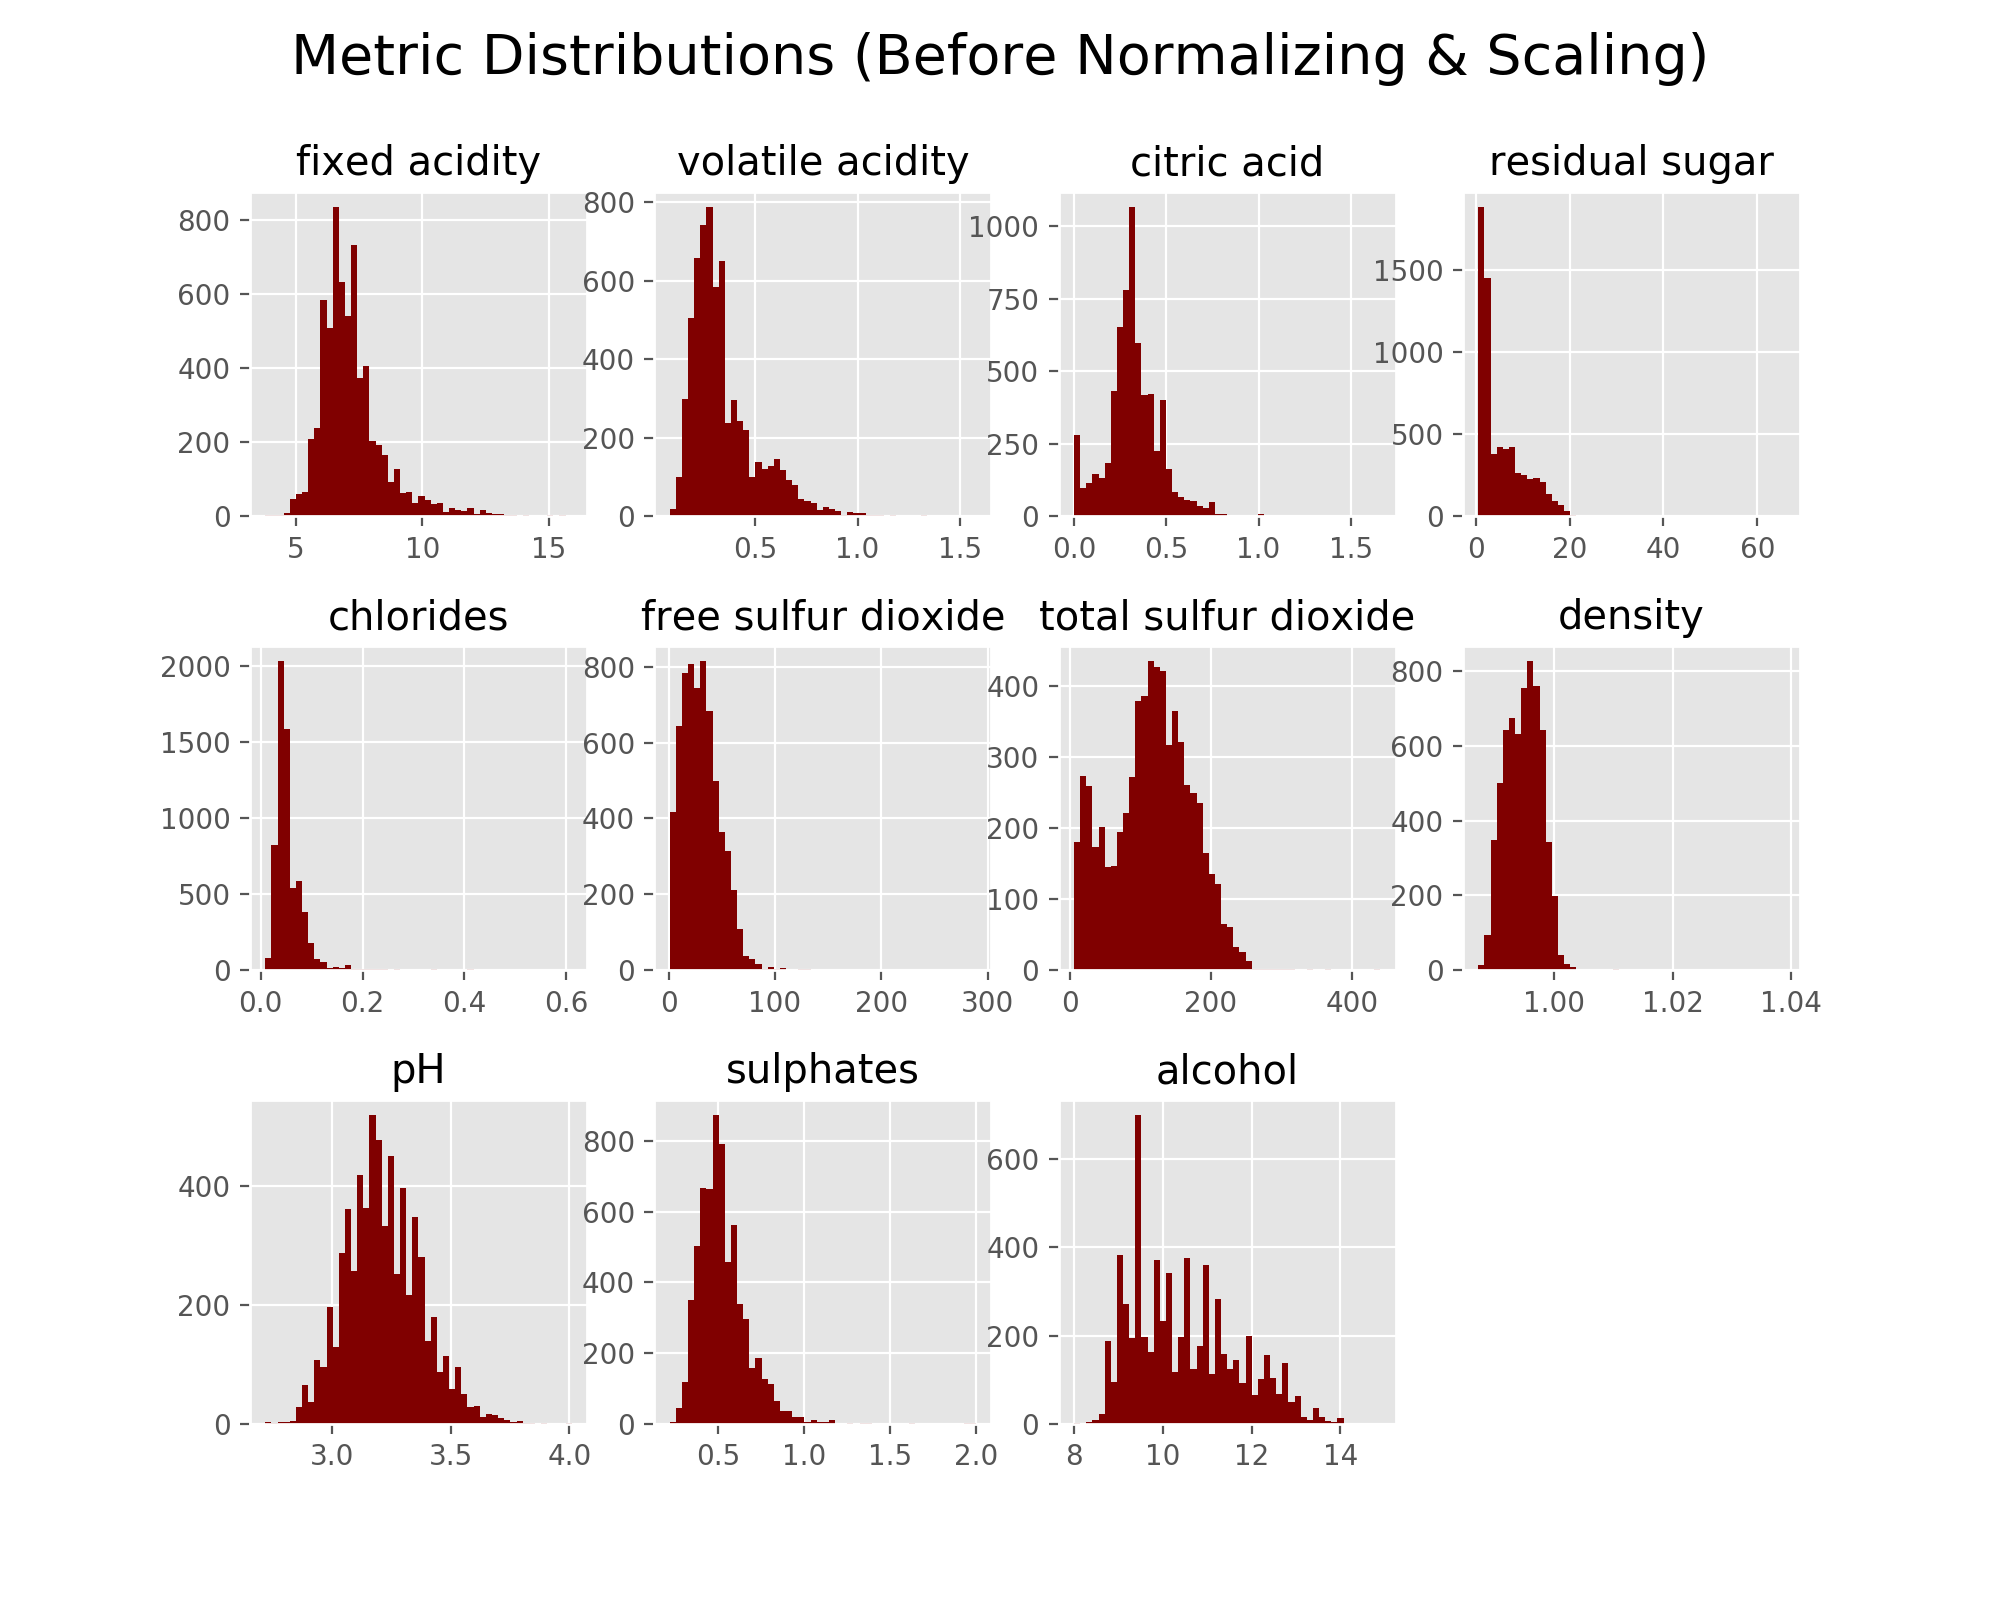

In [8]:
#create a subplot showing a histogram for each metric
def show_metric_dist(df, title):
    plt.style.use('ggplot')
    plt.rcParams['figure.figsize']= [10, 8]
    fig = plt.figure()
    plt.subplots_adjust(hspace=0.4)
    
    fig.suptitle(title, fontsize=20, y=0.98)
    j=1
    for i, e in zip(df.columns.values, df.dtypes):
        if e not in [np.float64, np.int64]:
            continue
        ax=fig.add_subplot(3, 4, j)
        df[i].hist(bins=50, color='maroon')
        ax.set_title(i)
        j+=1
        
    plt.show()


show_metric_dist(wines, title='Metric Distributions (Before Normalizing & Scaling)')


We see that the distributions of many of these metrics is significantly skewed. In general, machine learning algorithms works best when metrics have a roughly gaussian distribution. We will need to normalize this data in addition to scaling it. 

We first normalize the data using boxcox. A shift is manually added as suggested in the documentation:
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html


We use the MinMaxScaler to normalize the data such that all metrics range from 0 to 1. 

In [9]:
#test alternative normalization
from sklearn.preprocessing import MinMaxScaler
from scipy import stats

#scale to gaussian
wines_mets= drop_dims(wines)
wines_scaled = wines_mets.apply(lambda x: stats.boxcox(x+1e-8)[0], axis=0)

scaler = MinMaxScaler()

wines_norm = pd.DataFrame(wines_scaled)

wines_norm = pd.DataFrame(scaler.fit_transform(wines_scaled), columns=wines_scaled.columns)

# Show an example of a record with scaling applied
display(wines_norm.describe())

fixed acidity  volatile acidity  citric acid  residual sugar  \
count    6497.000000       6497.000000  6497.000000     6497.000000   
mean        0.650133          0.545262     0.344065        0.481573   
std         0.106679          0.147462     0.112068        0.194062   
min         0.000000          0.000000     0.000000        0.000000   
25%         0.584444          0.452059     0.305496        0.317700   
50%         0.650531          0.534630     0.349562        0.444608   
75%         0.712808          0.640662     0.403624        0.659220   
max         1.000000          1.000000     1.000000        1.000000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  6497.000000          6497.000000           6497.000000  6497.000000   
mean      0.632338             0.287469              0.294360     0.233174   
std       0.100388             0.105376              0.139639     0.084177   
min       0.000000             0.000000              0.000000     0.000000   
25%       0.569905             0.214033              0.203681     0.167640   
50%       0.625942             0.295767              0.305306     0.241769   
75%       0.701352             0.360535              0.395040     0.299381   
max       1.000000             1.000000              1.000000     1.000000   

                pH    sulphates      alcohol  
count  6497.000000  6497.000000  6497.000000  
mean      0.496521     0.498610     0.545778  
std       0.130755     0.124101     0.181151  
min       0.000000     0.000000     0.000000  
25%       0.411721     0.415784     0.395985  
50%       0.497602     0.502740     0.543658  
75%       0.584713     0.579464     0.688291  
max       1.000000     1.000000     1.000000

<IPython.core.display.Javascript object>


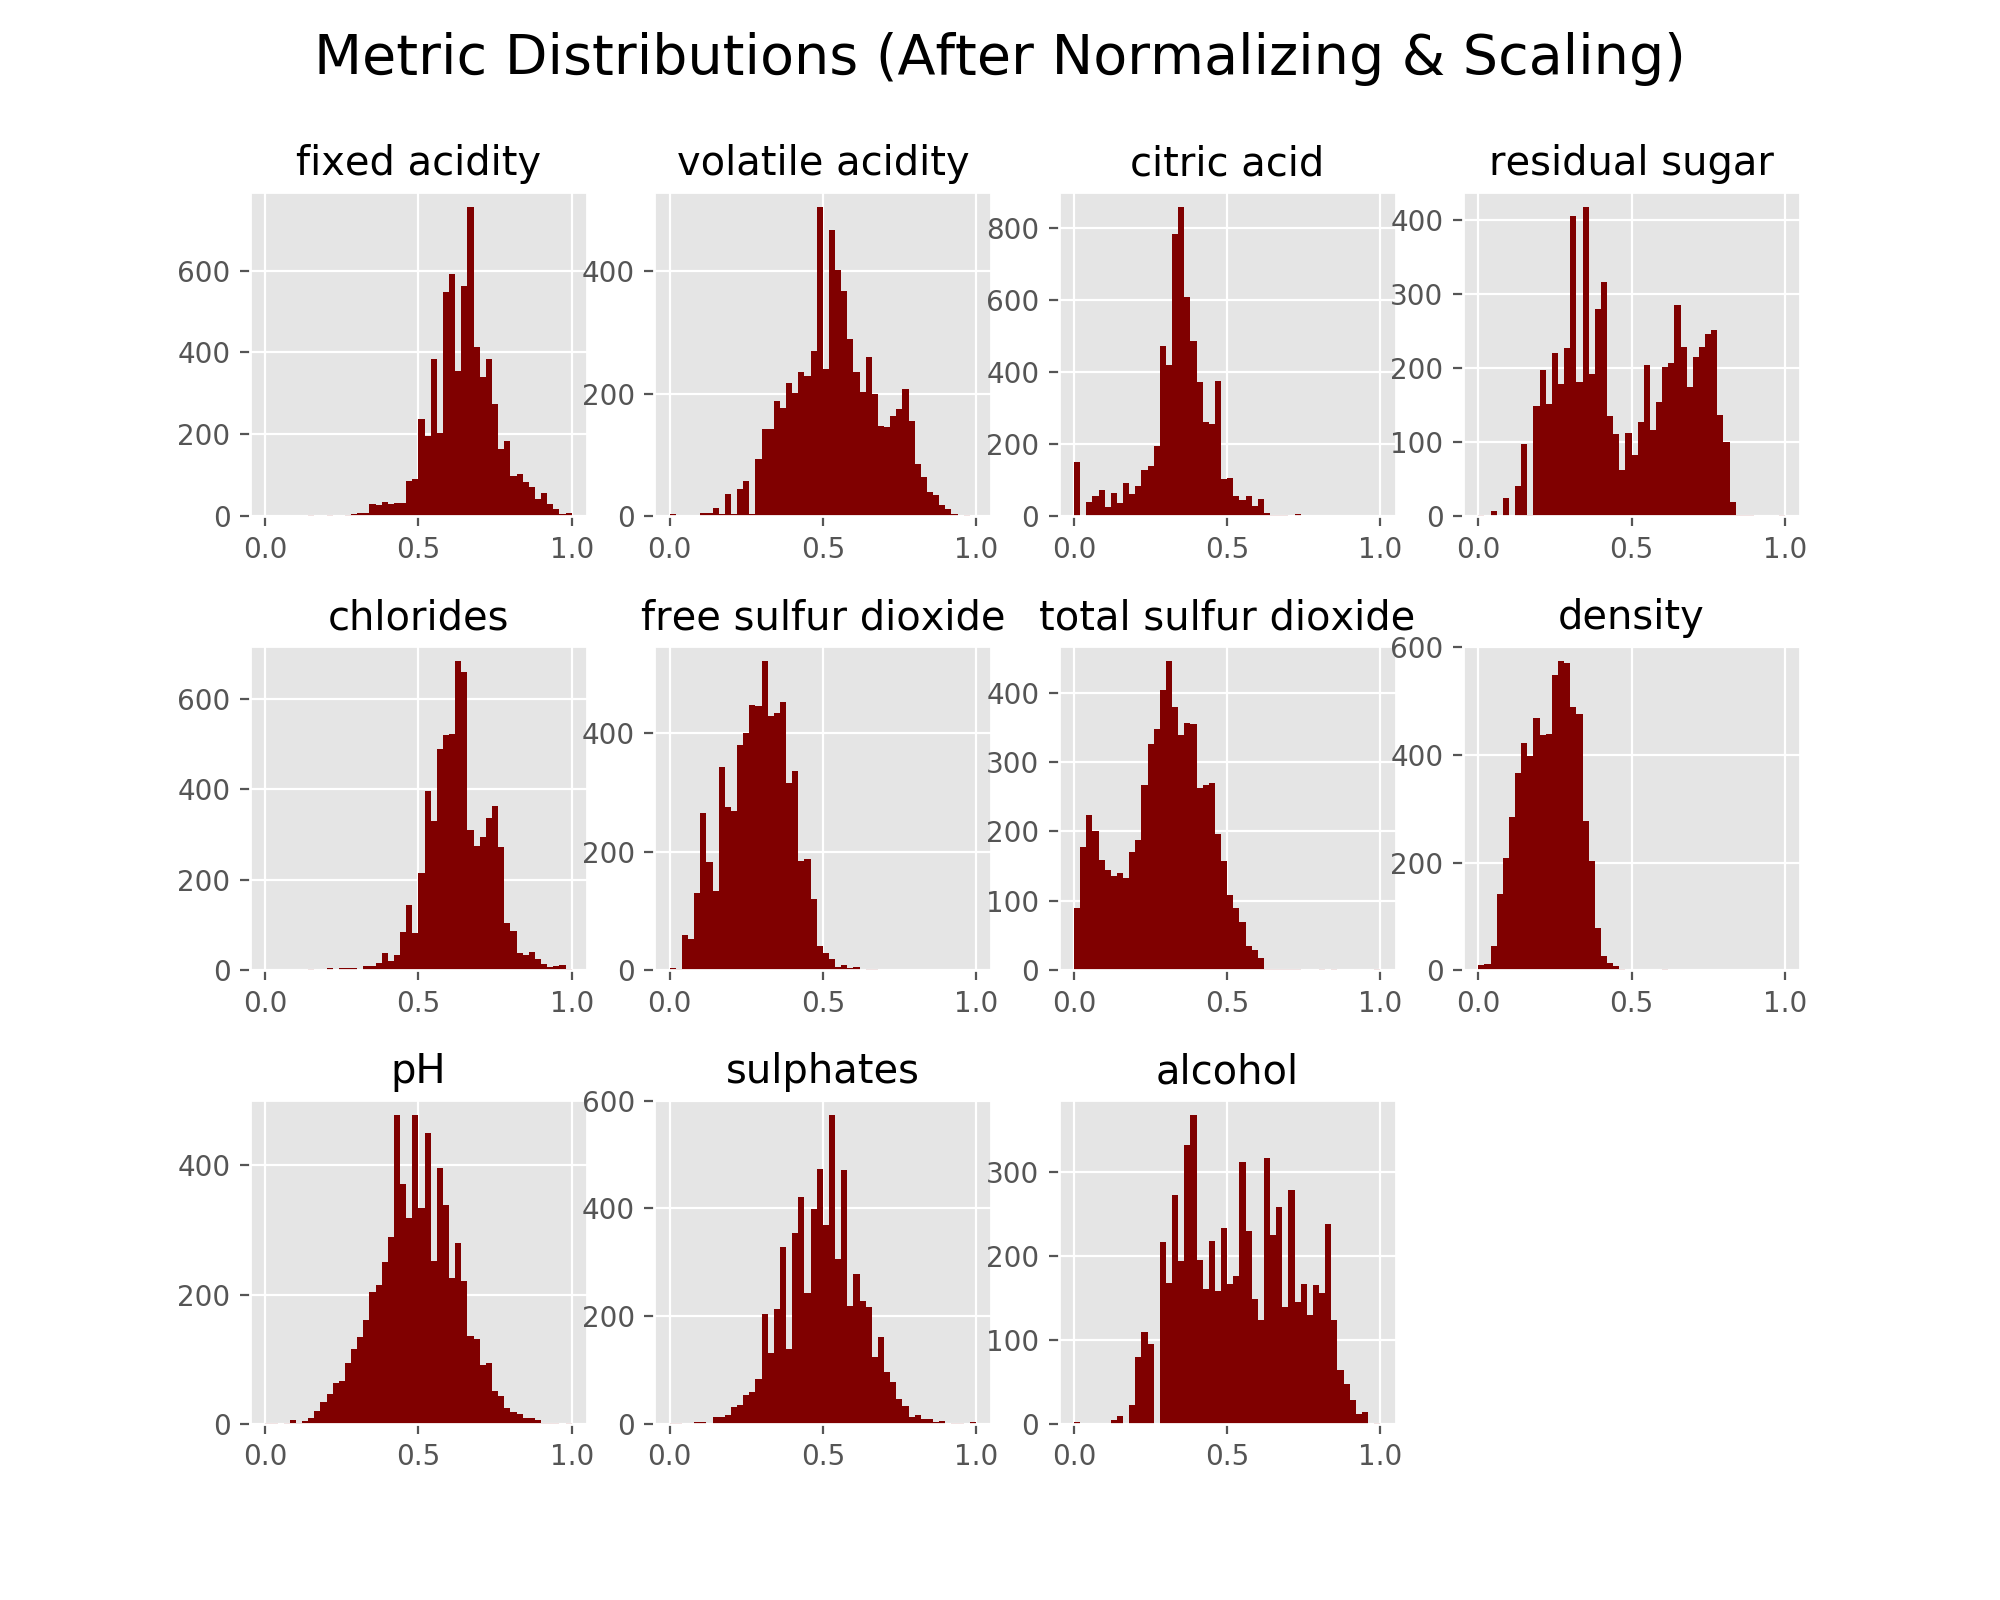

In [10]:
show_metric_dist(wines_norm, title='Metric Distributions (After Normalizing & Scaling)')


As seen above, all metrics are now roughly gaussian and have a range from 0 to 1. This data is now optimal input for typical machine learning algorithms. 

Before proceeding, we will perform a principal component analysis (PCA). PCA is a technique in which a set of normal axes are greedily chosen such that each axis is oriented such that variance is maximized along that axis. We will perform PCA in order to determine several things:

1) The minimum number of dimensions necessary to preserve the majority of the information (variance) contained in our data. This will be of interest to use if we decide to use fewer dimensions to our ML algorithm in the interest of boosting performance.

2) This will help us determine whether a 3D visualization will be sufficient to see some of the inherent structure in our data. 

We will perform a PCA transformation using the same number of dimensions as our existing dataset. We will then calculate the percentage of the overall variance can be encoded in 1, 2, ... n dimensions. We will then examine the first component of our PCA transformed data to identify which metrics account for the most variance.

In [11]:
# Apply PCA by fitting the data with the same number of dimensions as features
from sklearn.decomposition import PCA
pca = PCA(n_components=wines_norm.shape[1], random_state=51)
pca.fit(wines_norm)

#Transform wines_norm using the PCA fit above
pca_samples = pca.transform(wines_norm)

In [12]:
for i in range(wines_norm.shape[1]):

    first_n = pca.explained_variance_ratio_[0:i+1].sum()*100
    print('Percent variance explained by first {} components: {:.1f}%'.format(i+1, first_n))


print('\nFirst principle component contributions:\n')
first_comp= zip(wines_norm.columns.values, pca.components_[0])

for i, j in first_comp:
    print(i, '%.3f' % j)


Percent variance explained by first 1 components: 32.0%
Percent variance explained by first 2 components: 53.6%
Percent variance explained by first 3 components: 65.2%
Percent variance explained by first 4 components: 75.8%
Percent variance explained by first 5 components: 83.6%
Percent variance explained by first 6 components: 89.3%
Percent variance explained by first 7 components: 93.1%
Percent variance explained by first 8 components: 95.9%
Percent variance explained by first 9 components: 98.1%
Percent variance explained by first 10 components: 99.7%
Percent variance explained by first 11 components: 100.0%

First principle component contributions:

('fixed acidity', '-0.026')
('volatile acidity', '-0.193')
('citric acid', '0.130')
('residual sugar', '0.651')
('chlorides', '-0.035')
('free sulfur dioxide', '0.263')
('total sulfur dioxide', '0.415')
('density', '0.158')
('pH', '-0.208')
('sulphates', '-0.131')
('alcohol', '-0.440')


We can see that the majority of the variance in our data (>95%) can be encoded in 8 of our 11 dimensions. We see that over 65% of our variance can be encoded in 3 dimensions. This suggests that we can expect to see some of the underlying structure in a 3D visualization, but much of it will still be hidden. 

In the breakdown of the first principle component that follows, we see that residual sugar, alcohol, and total sulfur dioxide were assigned the highest coefficients, which indicate these are the metrics with the greatest contribution to the variance of our data. This seems to agree with the transformed histogram distributions displayed earlier. 

While we will use all 11 metrics in our clustering algorithm, we will first map our our data to 3 dimensions using PCA and visualize. We will return to this compressed dataset after assigning labels to all of our records to visualize the results of our clustering efforts. 

In [13]:
pca_3d = PCA(n_components=3, random_state=51)
pca_3d.fit(wines_norm)

#transform wines_norm using the PCA fit above
pca_samples_3d = pca_3d.transform(wines_norm)

<IPython.core.display.Javascript object>


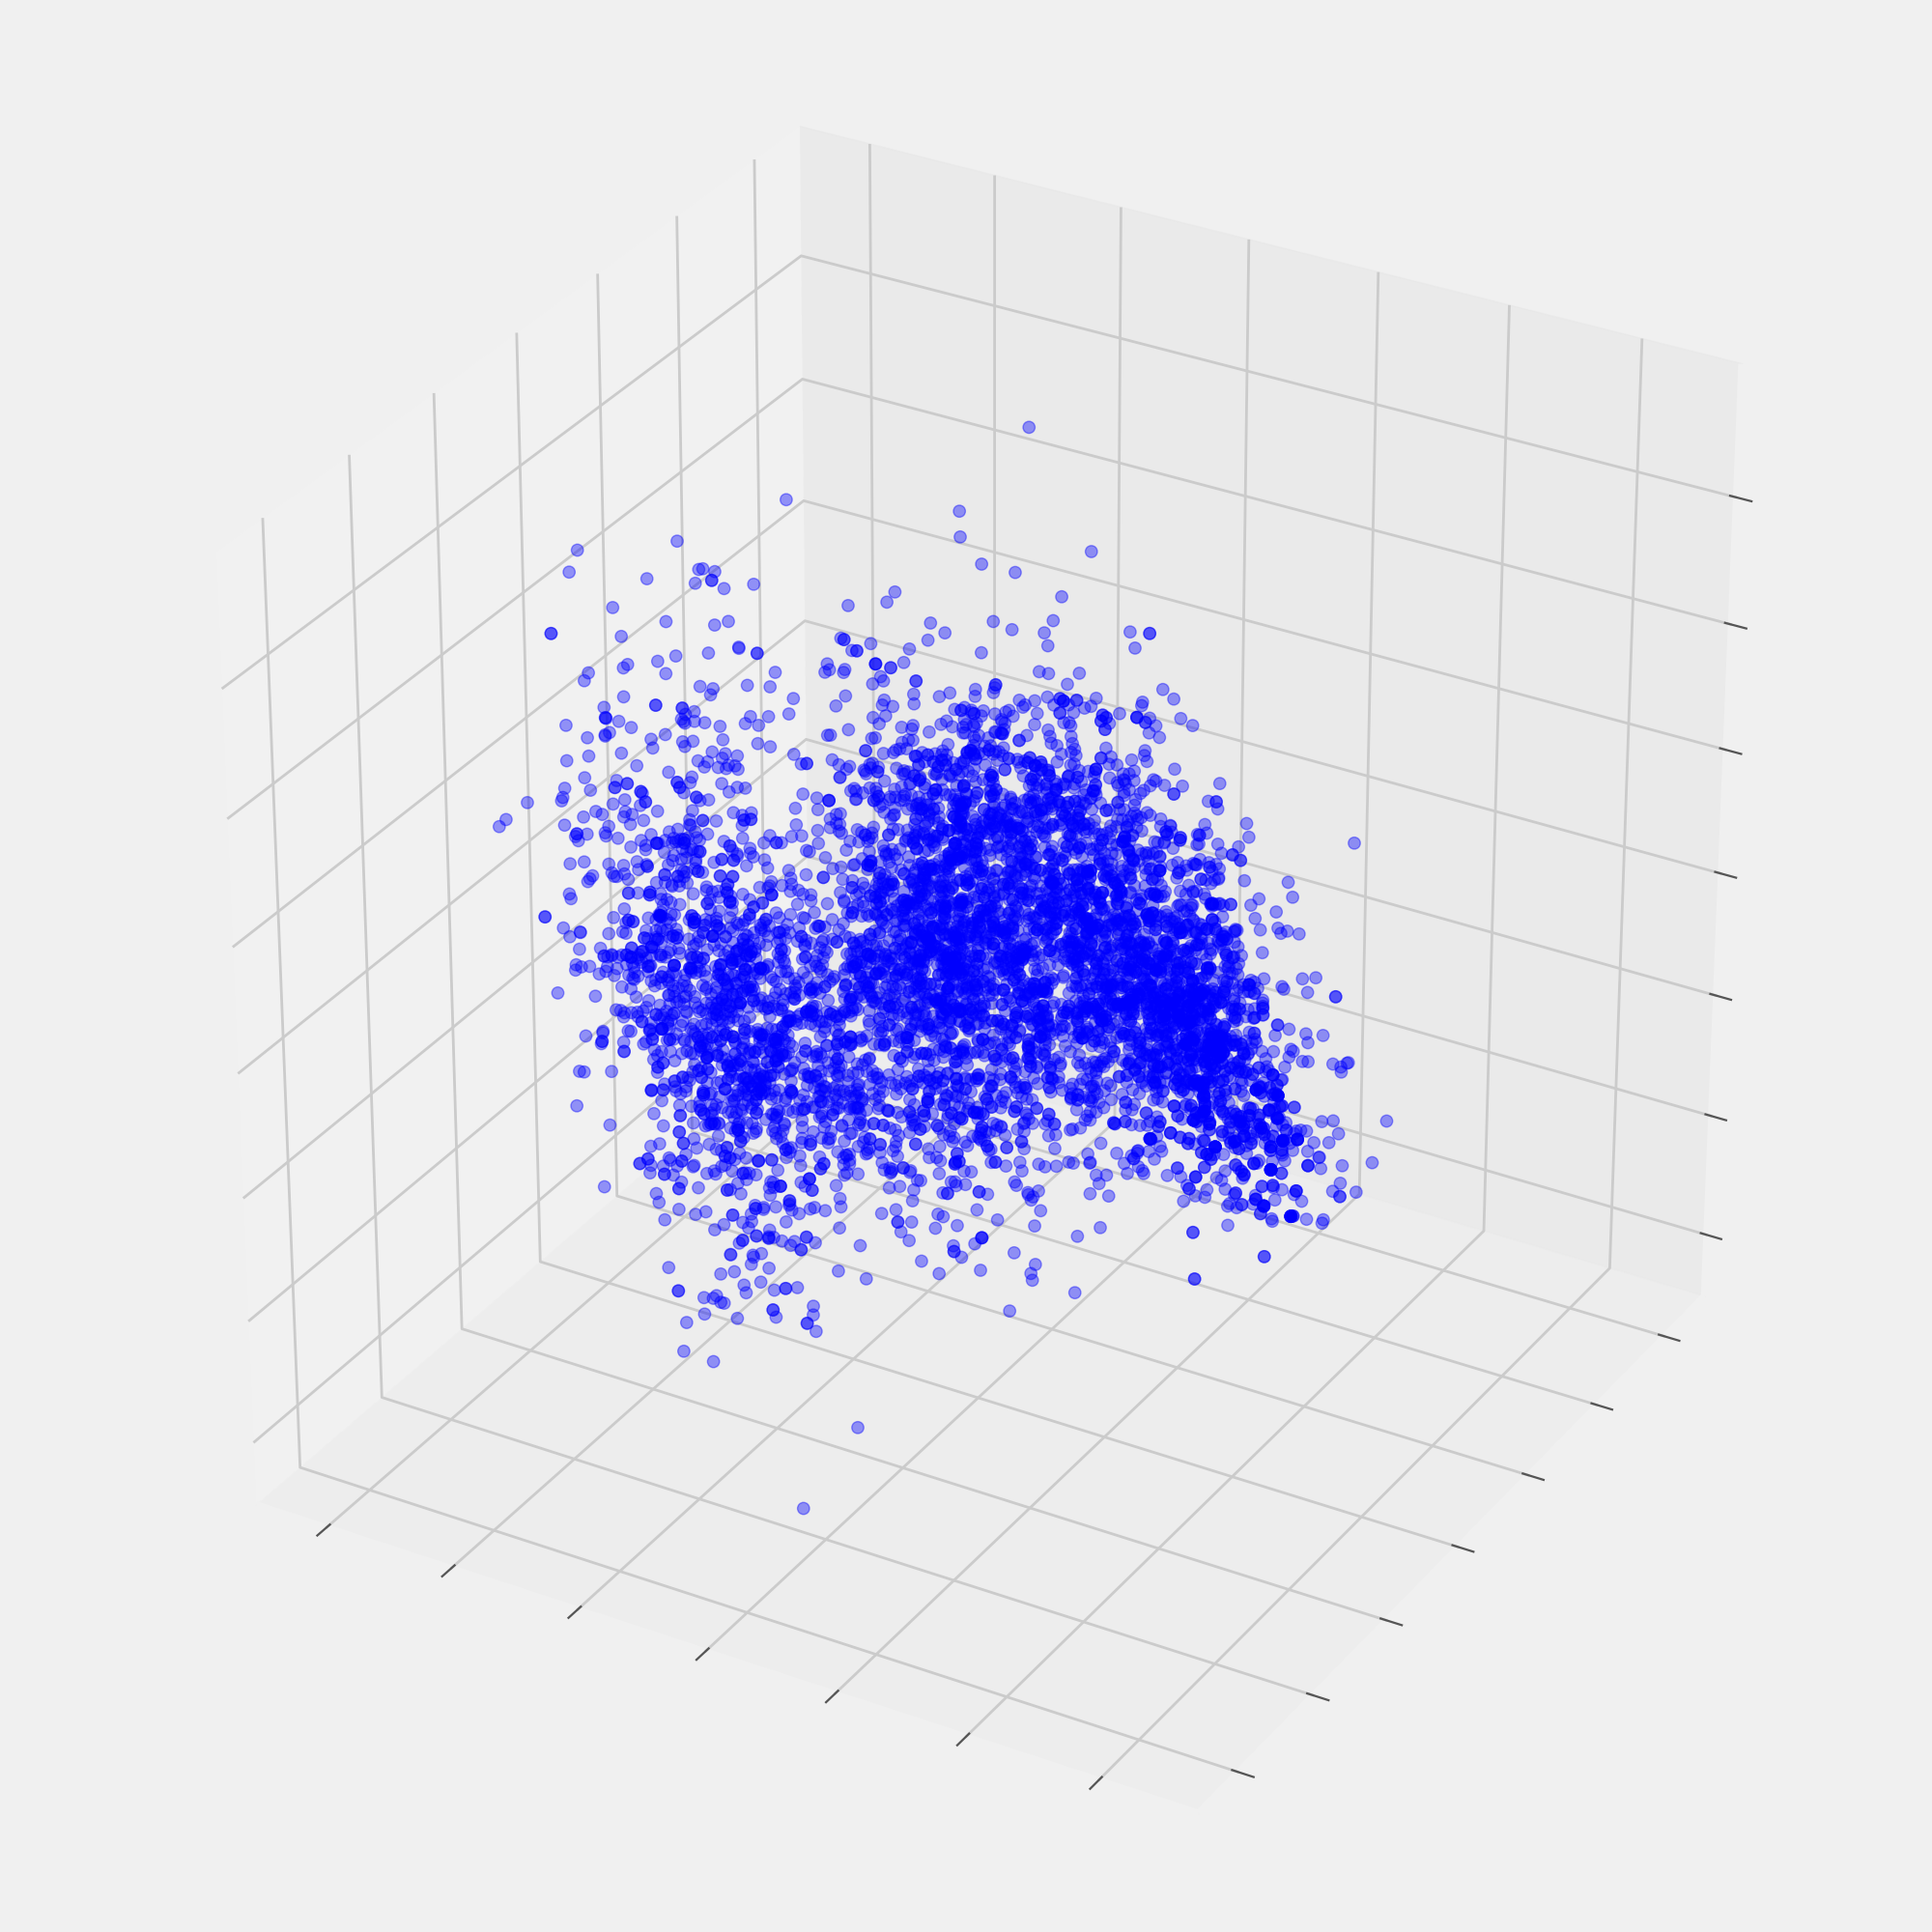

In [15]:
#visualize our PCA transformed data
from mpl_toolkits.mplot3d import Axes3D

plt.style.use('fivethirtyeight')
fig = plt.figure(figsize= (10, 10))
ax = Axes3D(fig)

ax.scatter(pca_samples_3d[:,0], pca_samples_3d[:,1], pca_samples_3d[:,2], alpha=0.4, color= 'b')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

plt.show()



If viewing in jupyter notebook, feel free to rotate this plot. From visual inspection, it looks like there are two distinct groups of wine here (likely red and white). Considering that only ~65% of the data's variance is encoded in this 3D plot, we will use an analytical approach before performing our clustering task rather than assuming that 2 clusters is the most reasonable number of groups. 

This analytical will be done as follows:

1) We will fit our clustering algorithm using several different values of k where k is the number of clusters. We will have k range from 2 to 20. 

2) For each value of k, we will evaluate the clustering results using the average silhouette score. We will plot the sillhouette score against each k value and identify which number of clusters leads to the best results. 

3) We will then assign cluster labels to our dataset using the fitted clustering model with the optimal number of clusters k. 

The sillhouette score can be roughly described as a measure of how close a sample is to members of its own cluster as compared to members of other clusters. The silhoette score ranges from -1 to 1. A score close to one indicates that a record is very close to other members of its cluster and far from members of other clusters. A score of 0 indicates that a record lies on the decision boundary between two clusters. A negative score indicates that a sample is closer to members of a cluster other than its own. By taking the average silhouette score for all records when various number of clusters are used in our clustering algorithm, we can find the optimal number of clusters that promotes cohesion within individual clusters and good seperability between the clusters. 

For the clustering algorithm itself, a Gaussian Mixture Model was chosen. This was chosen for several reasons, including the fact that gaussian mixture models allow for mixed membership; GMM models assign probabilities that a given record belongs to a given cluster. This property may be useful for classifying wines which are blends of multiple types. For example, a wine may be a blend of Cabernet Sauvignon, Merlot. 

Another reason for choosing a GMM is that they are more flexible with regards to cluster shapes which deviate from a hyper-spherical one. It is impossible for us to directly observe the actual cluster shapes visually since they exist in an 11-dimensional space, so it is helpful to have a clustering algorithm with such flexibility. 





In [16]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

max_k=20

sil_scores=[]
for i in range(2, max_k+1):
    clusterer = GaussianMixture(n_components=i, random_state=51, n_init=5)
    clusterer.fit(wines_norm)

    #Predict the cluster for each data point
    preds = clusterer.predict(wines_norm)

    #Find the cluster centers
    centers = clusterer.means_

    #Predict the cluster for each transformed sample data point
    sample_preds = clusterer.predict(wines_norm)

    #Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(wines_norm, preds)
    sil_scores.append(score)
    
sil_scores= pd.Series(sil_scores, index= range(2,max_k+1))
max_score= sil_scores.max()
n_clusters= sil_scores.idxmax()
print('Max Silhouette Score: {:.3f}'.format(max_score))
print('Number of clusters: {}\n'.format(max_k))

print('First 3 Silhouette Scores')
print(sil_scores[0:3])

#refit the model to the K with the max silhouette score
clusterer = GaussianMixture(n_components=n_clusters, random_state=51, n_init=5)
clusterer.fit(wines_norm)

#Predict the cluster for each data point
preds = clusterer.predict(wines_norm)

#Find the cluster centers
centers = clusterer.means_

Max Silhouette Score: 0.240
Number of clusters: 20

First 3 Silhouette Scores
2    0.213150
3    0.239939
4    0.221927
dtype: float64


<IPython.core.display.Javascript object>


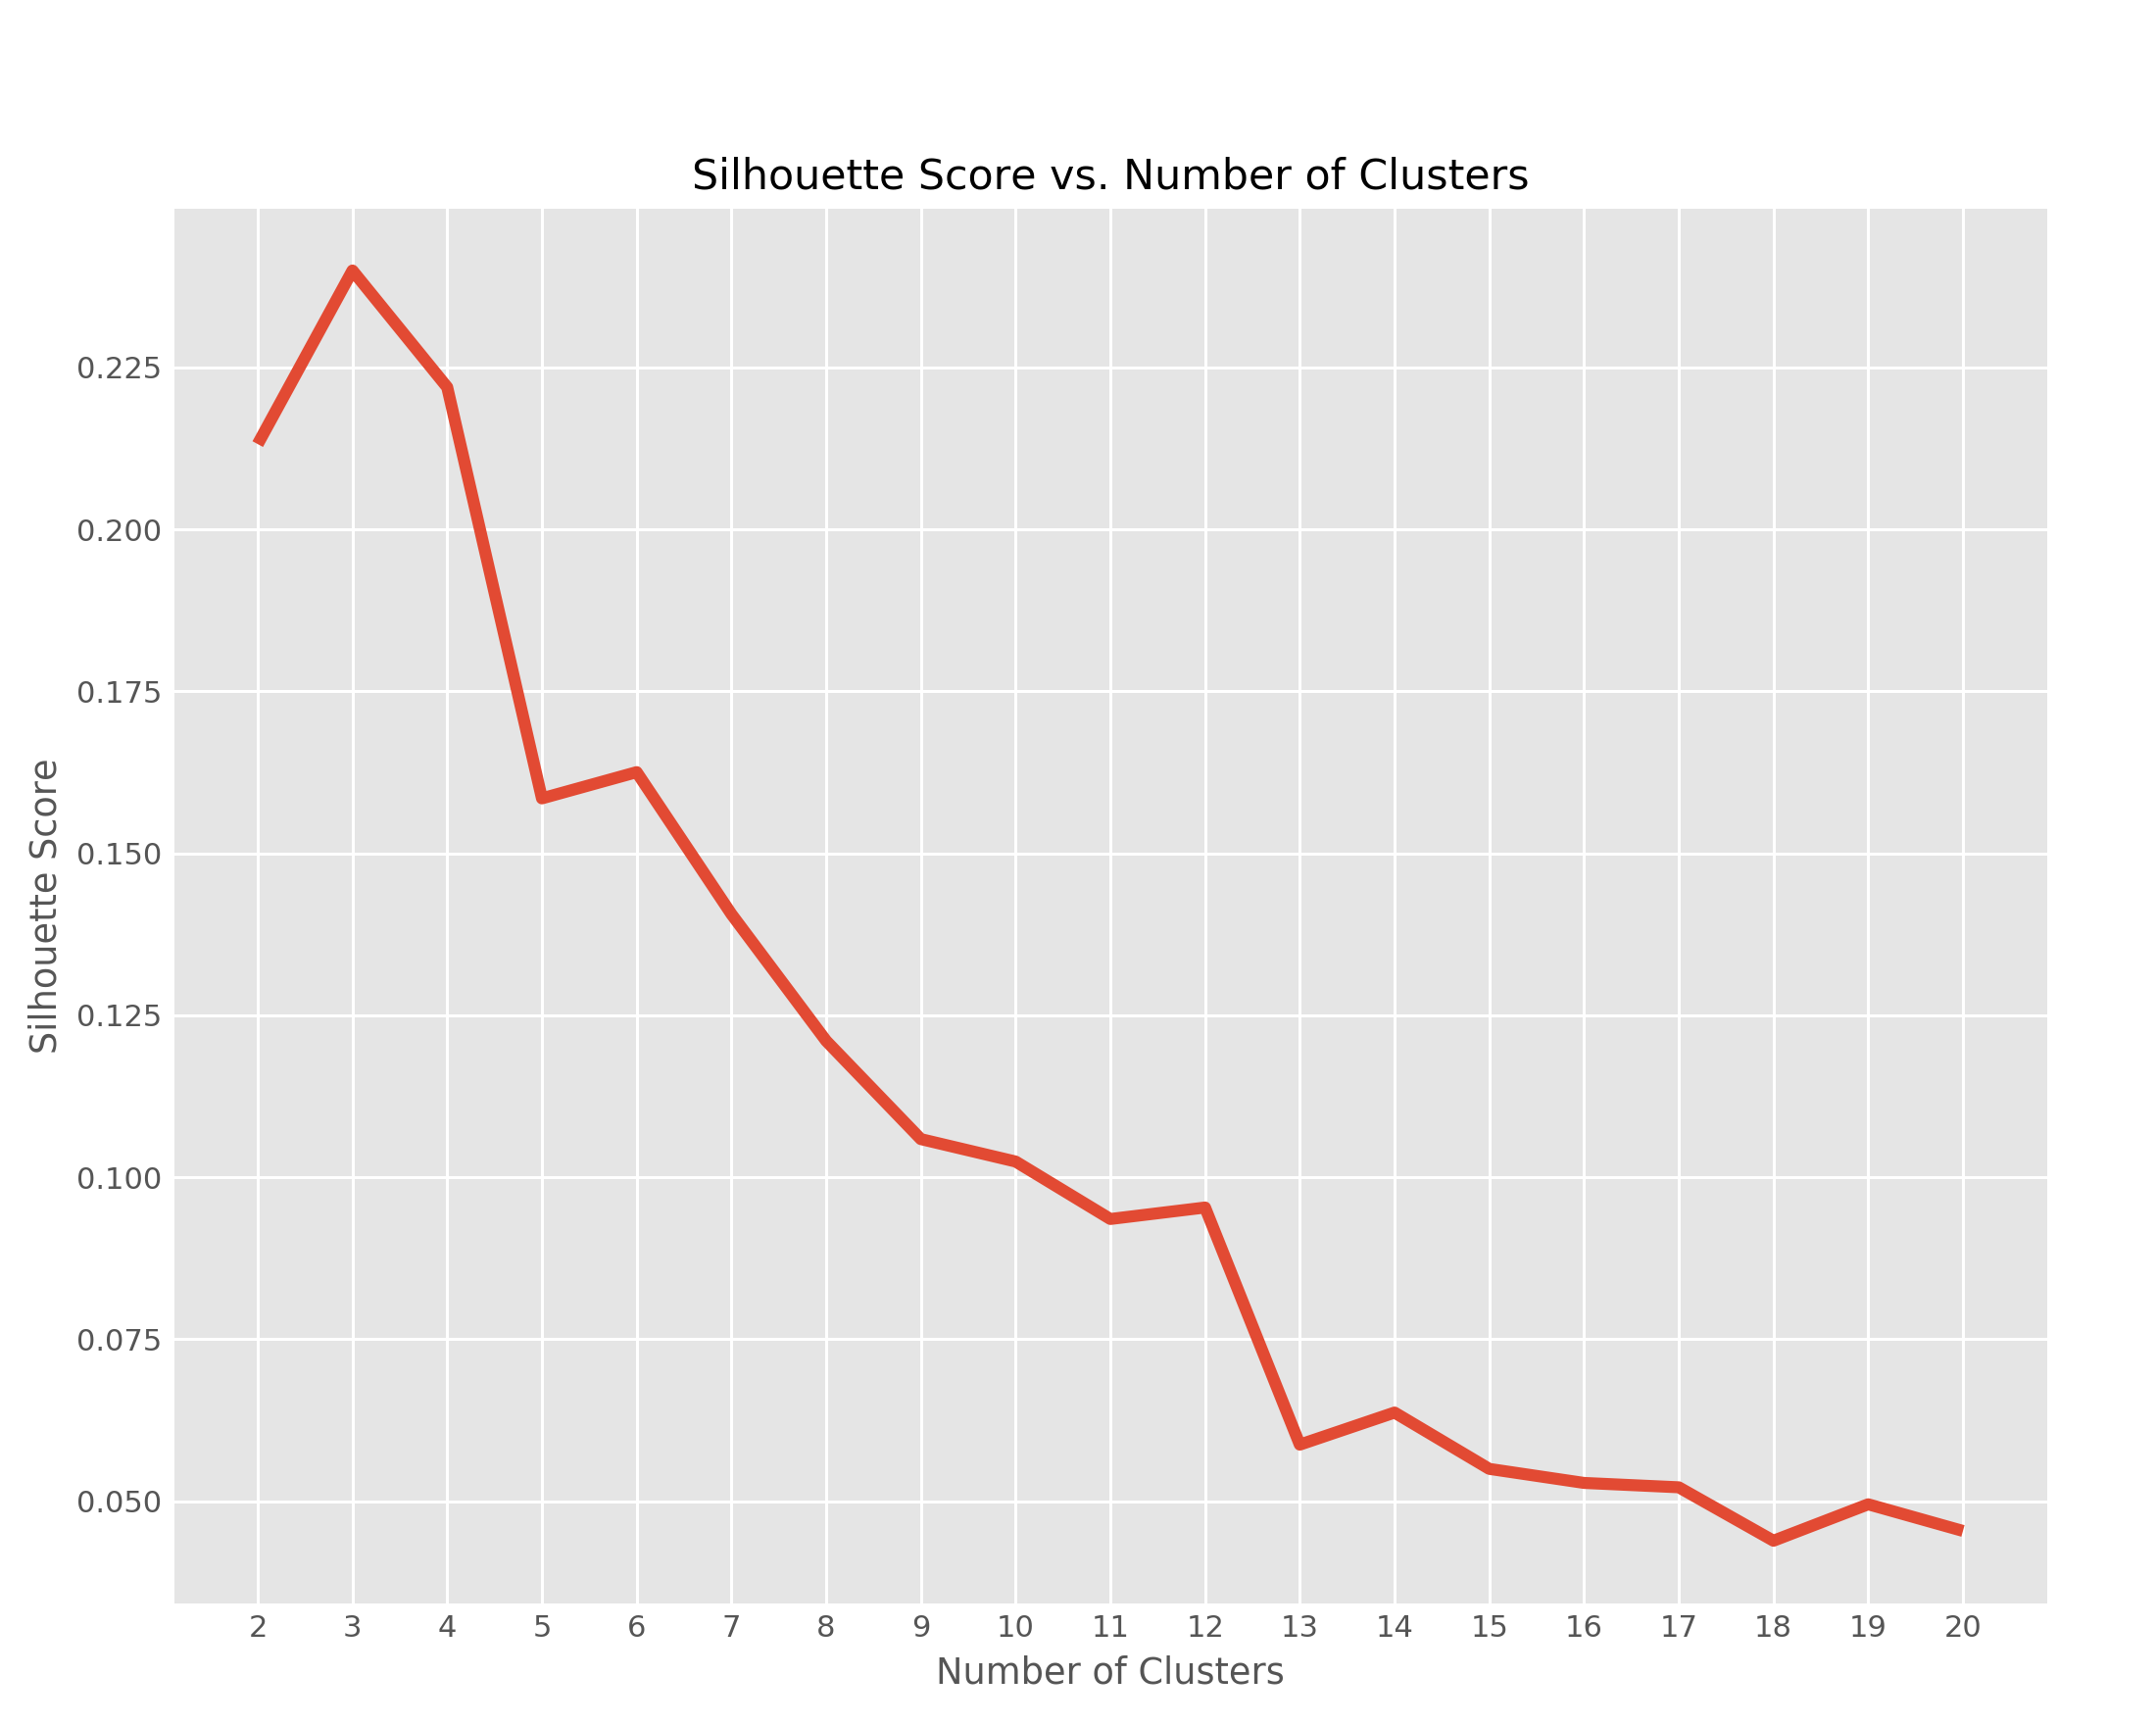

In [24]:
plt.style.use('ggplot')
plt.figure(figsize=(10,8))
plt.title('Silhouette Score vs. Number of Clusters', fontsize=14)
plt.ylabel('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.xticks(np.arange(2, max_k+1, 1))
plt.plot(sil_scores.index.values, sil_scores)


We see that the silhouette score is maximized when 3 clusters are used. Therefore, we fit the GMM using 3 clusters. We will now color each of our clusters and visualized the data in 3 dimensions again. We will append the wine type back to our dataset (red vs. white) to see how this property is distributed among our clusters.

In [19]:
#append cluster labels
pca_3d_clusters= np.append(pca_samples_3d, preds.reshape(-1, 1), axis=1)
#append wine type (red, white)
pca_3d_clusters= np.append(pca_3d_clusters, np.asarray(wines['type']).reshape(-1, 1), axis=1)


<IPython.core.display.Javascript object>


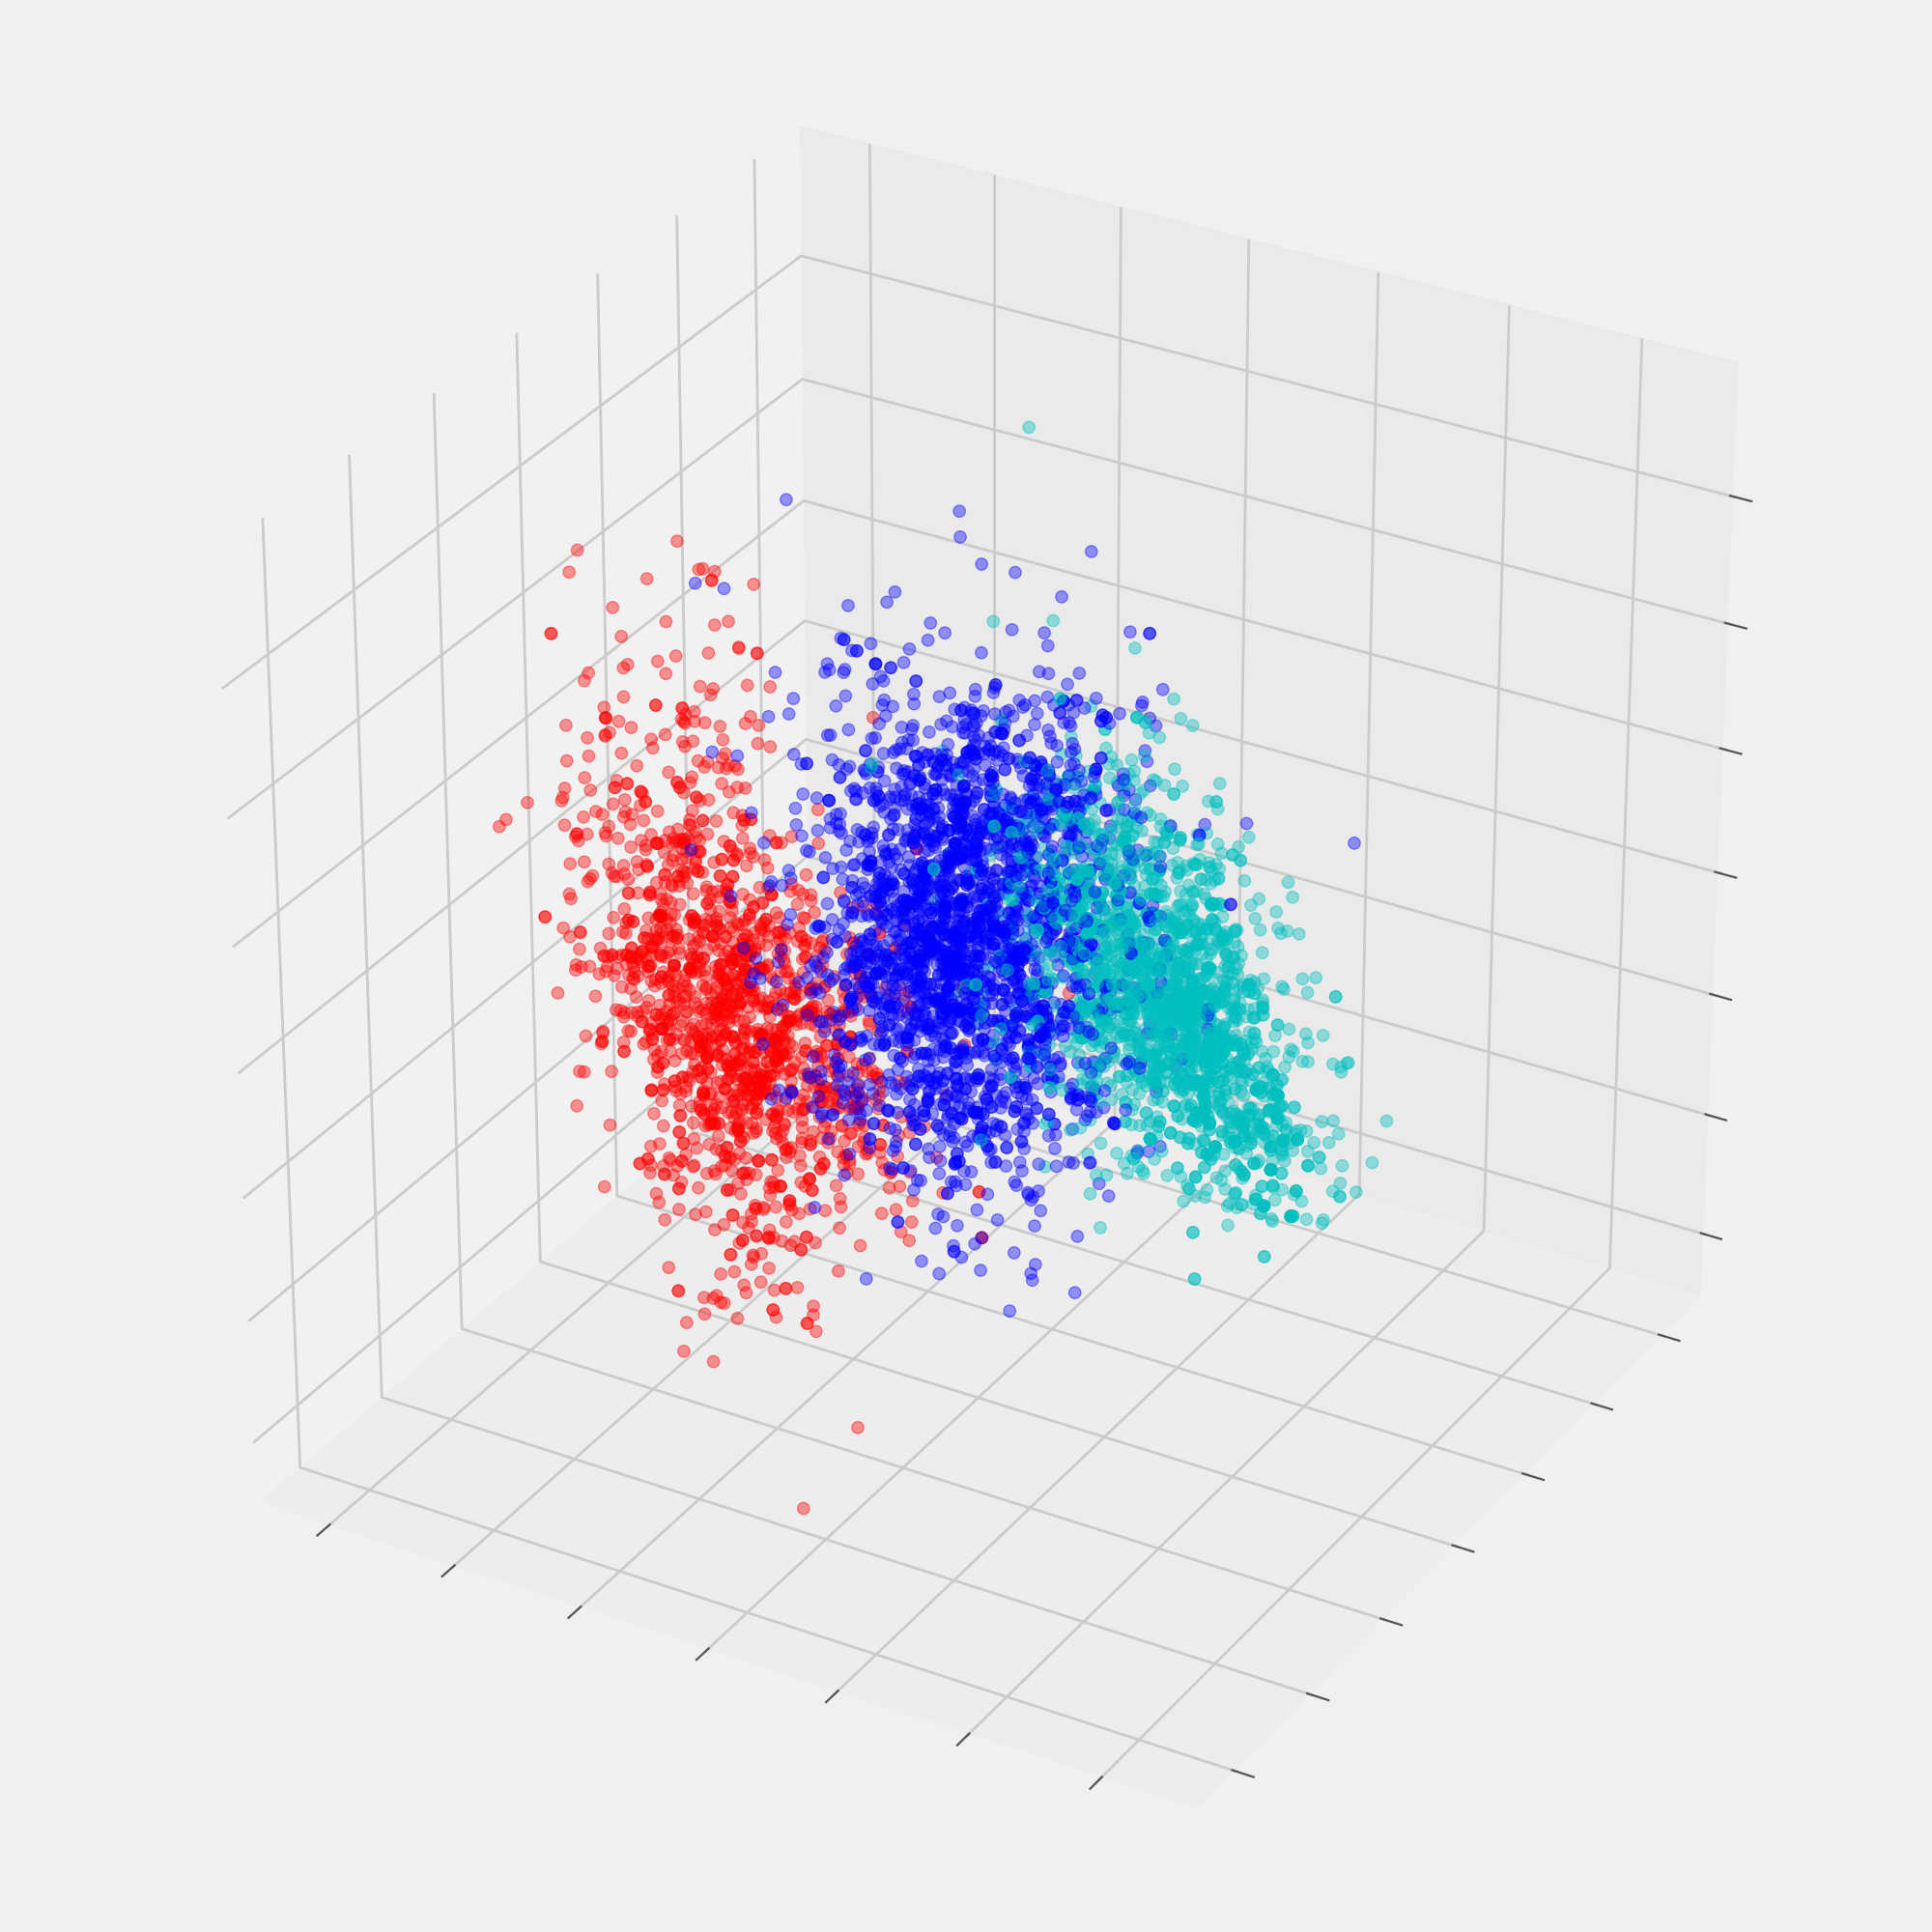

In [20]:
from mpl_toolkits.mplot3d import Axes3D

plt.style.use('fivethirtyeight')
fig = plt.figure(figsize= (10, 10))
ax = Axes3D(fig)

mapping= {0:'b', 1:'c', 2:'g'}
mapping= {0:'r', 1:'c', 2:'b'}
colors= [mapping[x] for x in preds]
ax.scatter(pca_3d_clusters[:,0], pca_3d_clusters[:,1], pca_3d_clusters[:,2], alpha=0.4, color= colors, marker= 'o')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

plt.show()

We see that our clusters are pretty well separated in 3d space. Now we will plot each of these clusters individually and color them red if the wine is a red wine and yellow if the wine is a white wine.

<IPython.core.display.Javascript object>


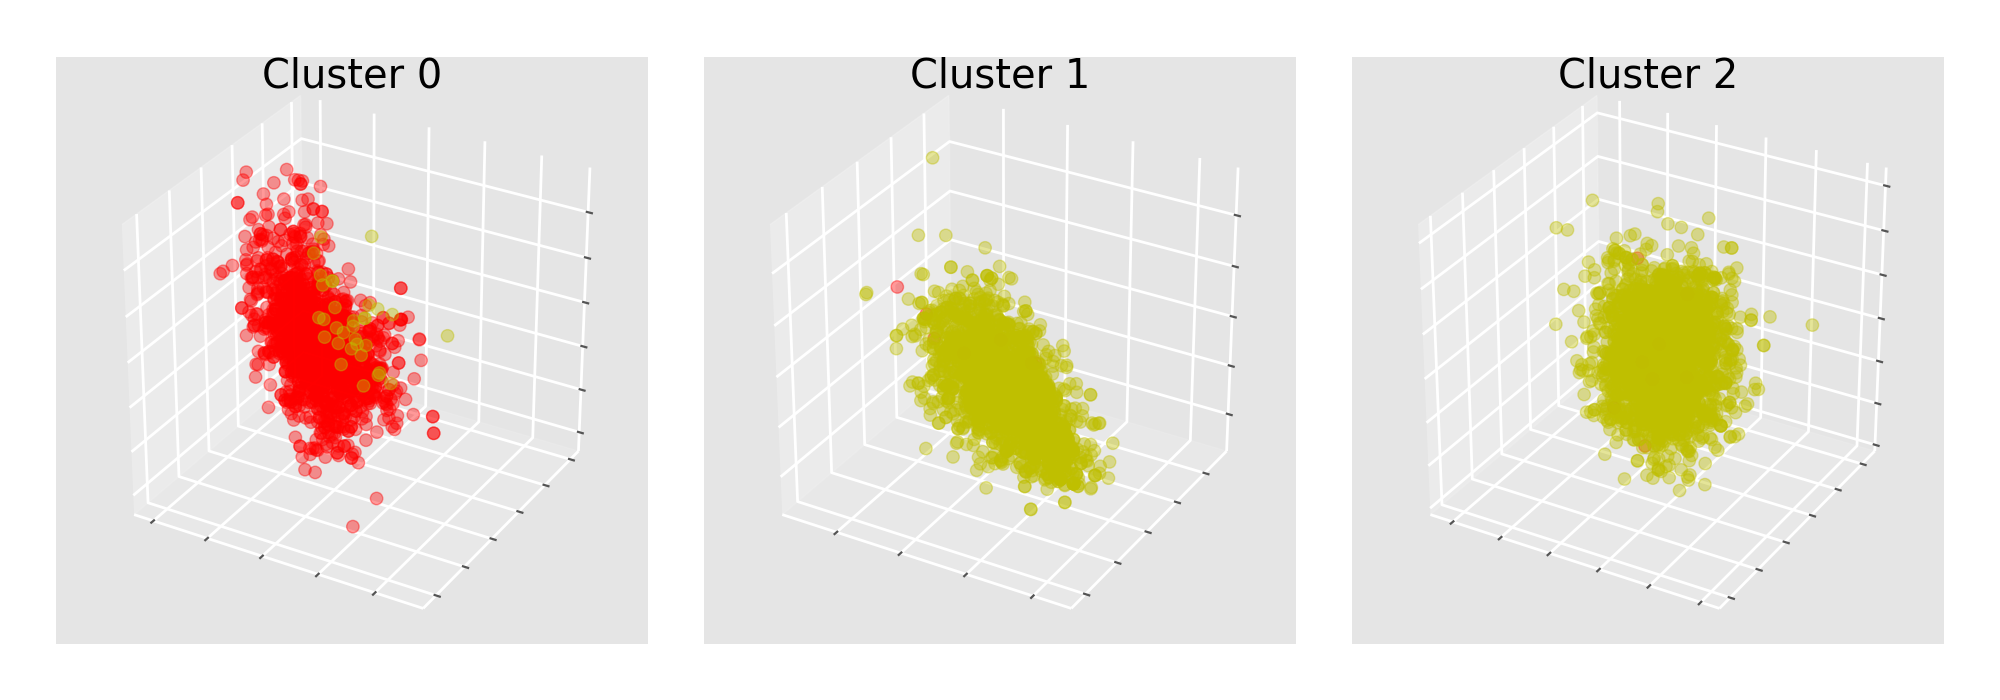

In [21]:
from mpl_toolkits.mplot3d import Axes3D

plt.style.use('ggplot')
plt.rcParams['figure.figsize']= [10, 3.5]
fig = plt.figure()

for i in range(3):

    ax=fig.add_subplot(1, 3, i+1, projection='3d')
    
    cluster_subset= pca_3d_clusters[pca_3d_clusters[:,3]==i]
    type_colors= np.where(cluster_subset[:,4]=='red', 'r', 'y')
    ax.scatter(cluster_subset[:,0], cluster_subset[:,1], cluster_subset[:,2], alpha=0.4, color= type_colors, marker= 'o')
    
    ax.set_title('Cluster {}'.format(i))
    
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    
plt.tight_layout(pad=2.0)

plt.show()

We see that the first cluster is almost entirely composed of red wines, and the other two clusters are almost entirely composed of white wines. It appears that our clustering algorithm has recognized the distinction of red and white wines and has also recognized two distinct categories of white wines. Let's now look at some descriptive statistics of each of the clusters.

In [22]:
wines['cluster']= pca_3d_clusters[:, 3]

In [23]:
for i in range(3):
    print('Cluster {}'.format(i))
    subset= wines[wines['cluster']==i]
    display(subset.describe())

Cluster 0


fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1614.000000       1614.000000  1614.000000     1614.000000   
mean        8.309046          0.529260     0.268302        2.490149   
std         1.741305          0.178434     0.197850        1.298619   
min         4.600000          0.120000     0.000000        0.800000   
25%         7.100000          0.400000     0.090000        1.900000   
50%         7.900000          0.520000     0.250000        2.200000   
75%         9.200000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.660000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1614.000000          1614.000000           1614.000000  1614.000000   
mean      0.087113            15.881351             46.659851     0.996727   
std       0.046982            10.409785             32.303138     0.001886   
min       0.022000             1.000000              6.000000     0.990800   
25%       0.070000             7.000000             22.000000     0.995600   
50%       0.079000            14.000000             38.000000     0.996710   
75%       0.090000            21.000000             63.000000     0.997815   
max       0.611000            72.000000            197.000000     1.003690   

                pH    sulphates      alcohol  
count  1614.000000  1614.000000  1614.000000  
mean      3.312726     0.655805    10.404802  
std       0.154364     0.168545     1.055600  
min       2.740000     0.320000     8.400000  
25%       3.210000     0.550000     9.500000  
50%       3.310000     0.620000    10.100000  
75%       3.400000     0.730000    11.000000  
max       4.010000     2.000000    14.900000

Cluster 1


fixed acidity  volatile acidity  citric acid  residual sugar  \
count    2261.000000       2261.000000  2261.000000     2261.000000   
mean        6.925475          0.279080     0.346471       10.854091   
std         0.740798          0.094659     0.128941        3.919526   
min         3.800000          0.090000     0.000000        4.400000   
25%         6.400000          0.220000     0.270000        7.700000   
50%         6.900000          0.260000     0.320000       10.400000   
75%         7.400000          0.320000     0.410000       13.500000   
max        11.800000          0.965000     1.230000       65.800000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  2261.000000          2261.000000           2261.000000  2261.000000   
mean      0.047564            41.345865            159.356258     0.996435   
std       0.015224            15.998265             40.150575     0.002274   
min       0.020000             2.000000             28.000000     0.990180   
25%       0.040000            30.000000            130.000000     0.995000   
50%       0.046000            41.000000            159.000000     0.996320   
75%       0.052000            52.000000            186.000000     0.998000   
max       0.301000           131.000000            366.500000     1.038980   

                pH    sulphates      alcohol  
count  2261.000000  2261.000000  2261.000000  
mean      3.166325     0.481079     9.850868  
std       0.141281     0.100637     0.925192  
min       2.720000     0.220000     8.400000  
25%       3.070000     0.410000     9.100000  
50%       3.160000     0.470000     9.600000  
75%       3.250000     0.540000    10.400000  
max       3.750000     1.010000    13.400000

Cluster 2


fixed acidity  volatile acidity  citric acid  residual sugar  \
count    2622.000000       2622.000000  2622.000000     2622.000000   
mean        6.791972          0.275204     0.325610        2.595156   
std         0.915424          0.101979     0.107865        1.754515   
min         3.900000          0.080000     0.000000        0.600000   
25%         6.200000          0.200000     0.270000        1.400000   
50%         6.700000          0.260000     0.310000        1.800000   
75%         7.300000          0.320000     0.370000        3.500000   
max        14.200000          1.100000     1.000000       13.000000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  2622.000000          2622.000000           2622.000000  2622.000000   
mean      0.044206            30.208810            120.663234     0.991947   
std       0.026211            16.132995             35.801858     0.001711   
min       0.009000             3.000000              9.000000     0.987110   
25%       0.033000            19.000000             97.000000     0.990700   
50%       0.039000            28.000000            118.000000     0.991880   
75%       0.047000            38.000000            142.000000     0.993140   
max       0.346000           289.000000            440.000000     0.998400   

                pH    sulphates      alcohol  
count  2622.000000  2622.000000  2622.000000  
mean      3.205492     0.497887    11.098042  
std       0.155607     0.125806     1.172691  
min       2.740000     0.230000     8.000000  
25%       3.100000     0.410000    10.200000  
50%       3.200000     0.480000    11.100000  
75%       3.300000     0.560000    12.000000  
max       3.820000     1.620000    14.200000

Based on the results above, it looks like the main quality distinguishing red wines from white wines is the sulfur dioxide content. This makes sense since red wines generally contain less sulfites than white wines. As for the two categories of white wines, it appears that the main quality distinguishing the two groups of white wines is the residual sugar. Cluster 1, with its higher residual sugar content, is likely composed of sweeter wines such as Rieslings and Ice Wines. Cluster 2, with its lower residual sugar content is likely composed of dryer wines such as Chardonnay and Muscadet.